In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM


from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [17]:
dataframe = pd.read_json('/Users/harshgupta/TSLA.json', convert_dates=['Time'])
print dataframe

         First    Last                Time
0       20.400   20.74 2010-08-02 09:00:00
1       20.740   20.56 2010-08-02 10:00:00
2       20.590   20.65 2010-08-02 11:00:00
3       20.630   20.67 2010-08-02 12:00:00
4       20.680   20.68 2010-08-02 13:00:00
5       20.690   20.79 2010-08-02 14:00:00
6       20.790   20.90 2010-08-02 15:00:00
7       20.920   20.92 2010-08-02 16:00:00
8       20.860   20.90 2010-08-03 09:00:00
9       20.880   21.39 2010-08-03 10:00:00
10      21.400   21.64 2010-08-03 11:00:00
11      21.710   21.49 2010-08-03 12:00:00
12      21.500   21.74 2010-08-03 13:00:00
13      21.740   21.85 2010-08-03 14:00:00
14      21.890   21.92 2010-08-03 15:00:00
15      21.950   21.95 2010-08-03 16:00:00
16      21.950   20.94 2010-08-04 09:00:00
17      20.990   21.35 2010-08-04 10:00:00
18      21.300   21.37 2010-08-04 11:00:00
19      21.320   21.44 2010-08-04 12:00:00
20      21.450   21.08 2010-08-04 13:00:00
21      21.060   21.18 2010-08-04 14:00:00
22      21.

In [19]:
dataset = (0.5*(dataframe['First'] + dataframe['Last'])).values
scaler = MinMaxScaler()
dataset = MinMaxScaler.fit_transform(scaler, dataset)

def rnnDataPrep(data, n_prev):
    X_data, y_data = [], []
    #naive version, vectorized version can be implemented,
    #but may run out of memory,
    for i in range(n_prev, len(data)):
        X_data.append(data[i - (n_prev):i].tolist())
    X_data = np.array(X_data)
    #print(X_data)
    y_data = data[n_prev:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data),))

def build_model_multilayer():
    model = Sequential()
    layers = [1, 50, 100, 1]
    
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model
    
def build_model_unilayer():
    model = Sequential()
    model.add(LSTM(input_dim=1, output_dim=4))
    model.add(Dense(output_dim=1))
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

In [20]:
ttR = 0.6
lb = 5
temp_x, temp_y = rnnDataPrep(dataset, 10)
X, y = rnnDataPrep(dataset, lb)
n = int(ttR * len(X))

In [21]:
X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

In [22]:
model_unilayer = build_model_unilayer()
model_unilayer.fit(X_train, y_train, nb_epoch=30, batch_size=1, verbose=2)

('Compilation Time : ', 0.008320093154907227)
Epoch 1/30
9s - loss: 2.3081e-04
Epoch 2/30
8s - loss: 3.7121e-05
Epoch 3/30
8s - loss: 3.4219e-05
Epoch 4/30
10s - loss: 2.8001e-05
Epoch 5/30
9s - loss: 2.5303e-05
Epoch 6/30
9s - loss: 2.1319e-05
Epoch 7/30
8s - loss: 1.9931e-05
Epoch 8/30
8s - loss: 1.8487e-05
Epoch 9/30
9s - loss: 1.8176e-05
Epoch 10/30
8s - loss: 1.8239e-05
Epoch 11/30
8s - loss: 1.7721e-05
Epoch 12/30
8s - loss: 1.7277e-05
Epoch 13/30
8s - loss: 1.7170e-05
Epoch 14/30
8s - loss: 1.7057e-05
Epoch 15/30
8s - loss: 1.6861e-05
Epoch 16/30
8s - loss: 1.6849e-05
Epoch 17/30
8s - loss: 1.6862e-05
Epoch 18/30
8s - loss: 1.6523e-05
Epoch 19/30
9s - loss: 1.6817e-05
Epoch 20/30
9s - loss: 1.6789e-05
Epoch 21/30
8s - loss: 1.6400e-05
Epoch 22/30
8s - loss: 1.6620e-05
Epoch 23/30
9s - loss: 1.6194e-05
Epoch 24/30
9s - loss: 1.6425e-05
Epoch 25/30
9s - loss: 1.7052e-05
Epoch 26/30
10s - loss: 1.6512e-05
Epoch 27/30
10s - loss: 1.6432e-05
Epoch 28/30
10s - loss: 1.5974e-05
Epoch 2

In [24]:
baseline_testScore = scaler.inverse_transform(np.array([[mean_squared_error(y_test[10:], y_test[:-10])**.5]]))
trainScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_train, y_train, verbose=0)**.5]]))
testScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_test, y_test, verbose=0)**.5]]))

print('baseline test score = %.2f RMSE' % baseline_testScore)
print('train score = %.2f RMSE' % trainScore)
print('test score = %.2f RMSE' % testScore)

baseline test score = 23.89 RMSE
train score = 18.60 RMSE
test score = 19.48 RMSE


In [26]:
# generate predictions
y_train_pred = model_unilayer.predict(X_train)
y_test_pred = model_unilayer.predict(X_test)

In [27]:
y = np.append(y_train, y_test)
print (y.shape)
print(len(dataframe['Time']))

(12270,)
12275


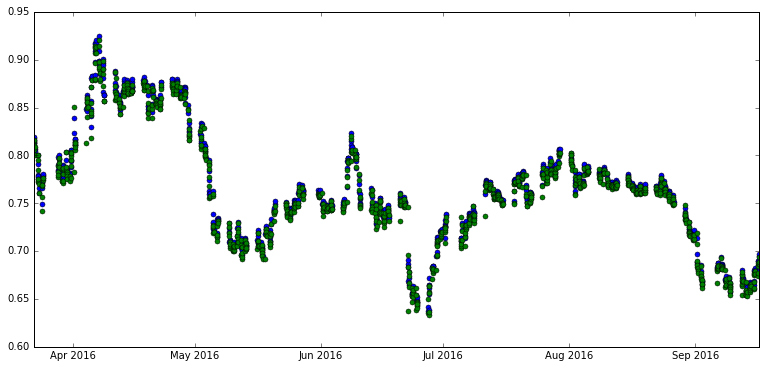

In [28]:
nn = 1000
plt.figure(figsize=(13, 6))
plt.plot(dataframe['Time'][3:][-nn:], np.append(y_train, y_test)[-nn:], 'o', ms=5)
#plt.plot(dataframe['Time'][3:][:n], y_train_pred, 'r')
plt.plot(dataframe['Time'][3:][n:][-nn:], y_test_pred[-nn:], 'o', ms=5, color='green')